# XGBoost Classifier

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, ndcg_score
import matplotlib.pyplot as plt

## Read dataset

In [3]:
df = pd.read_csv('/Users/ningyuhang/Desktop/EECS545/project/data/data_merged.csv')
# mean_popularity = 44.2
# df["popularity"] = [ 1 if i >= mean_popularity else 0 for i in df.popularity ]

In [4]:
df.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,...,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,Minor,Major
0,31.0,0.01270,0.622,218293.0,0.890,0.950000,0.124,-7.043,0.0300,115.002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,28.0,0.00306,0.620,215613.0,0.755,0.011800,0.534,-4.617,0.0345,127.994,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,34.0,0.02540,0.774,166875.0,0.700,0.002530,0.157,-4.498,0.2390,128.014,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,32.0,0.00465,0.638,222369.0,0.587,0.909000,0.157,-6.266,0.0413,145.036,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,46.0,0.02890,0.572,214408.0,0.803,0.000008,0.106,-4.294,0.3510,149.995,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Split train and test data

In [9]:
X  = df.drop('popularity', axis=1)
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [10]:
X_train.shape, X_test.shape

((28389, 34), (12167, 34))

## Training


In [11]:
dtrain_mse = xgb.DMatrix(X_train, label=y_train)
dtest_mse = xgb.DMatrix(X_test, label=y_test)

# Set up the parameters for MSE loss
params_mse = {
    'objective': 'reg:squarederror',
    'eta': 0.1,
    'max_depth': 6,
    'silent': 1,
    'seed': 42
}

# Train the model with MSE loss
num_rounds = 500
bst_mse = xgb.train(params_mse, dtrain_mse, num_rounds)

# Make predictions with the MSE model
y_pred_mse = bst_mse.predict(dtest_mse)
print(y_pred_mse)
# Calculate MSE
mse = mean_squared_error(y_test, y_pred_mse)
print(f"MSE: {mse}")

[01:26:31] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[37.026577 25.448902 44.099316 ... 33.05164  60.066856 24.266397]
MSE: 87.554706795631


In [12]:
from sklearn.preprocessing import StandardScaler

# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [13]:
from sklearn.model_selection import GridSearchCV

# Create a custom XGBoost ranking scorer for GridSearchCV
from sklearn.metrics import make_scorer

def custom_ndcg_score(y_true, y_pred):
    return ndcg_score(y_true.values.reshape(1, -1), y_pred.reshape(1, -1))

# Create a custom XGBoost ranking scorer for GridSearchCV
ranking_scorer = make_scorer(custom_ndcg_score, greater_is_better=True)

# Wrap the XGBoost ranking model for GridSearchCV
class XGBoostRanking():
    def __init__(self, params=None, num_rounds=100):
        self.params = params if params is not None else {}
        self.num_rounds = num_rounds

    def fit(self, X, y):
        dtrain = xgb.DMatrix(X, label=y)
        dtrain.set_group(np.array([X.shape[0]]))
        self.bst = xgb.train(self.params, dtrain, self.num_rounds)
        return self

    def predict(self, X):
        return self.bst.predict(xgb.DMatrix(X))

    def get_params(self, deep=True):
        return {'params': self.params, 'num_rounds': self.num_rounds}

    def set_params(self, **params):
        self.params = params.get('params', self.params)
        self.num_rounds = params.get('num_rounds', self.num_rounds)
        return self

# Define the parameter grid for the search
param_grid = {
    'params': [
        {
            'objective': 'rank:ndcg',
            'eta': eta,
            'max_depth': max_depth,
            'seed': 42,
        }
        for eta in [0.01, 0.05, 0.1]
        for max_depth in [4, 6, 8]
    ],
    'num_rounds': [100, 500],
}

# Instantiate the XGBoostRanking model and perform the grid search
xgb_ranking = XGBoostRanking({}, 0)
grid_search = GridSearchCV(xgb_ranking, param_grid, scoring=ranking_scorer, cv=3)
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the corresponding score
print("Best parameters found: ", grid_search.best_params_)
print("NDCG score: ", grid_search.best_score_)


Best parameters found:  {'num_rounds': 100, 'params': {'objective': 'rank:ndcg', 'eta': 0.01, 'max_depth': 4, 'seed': 42}}
NDCG score:  0.9533582049273321


In [49]:
# import pandas as pd

# # Assuming your target variable is in a pandas Series named 'y_train'
# label_counts = y_train.value_counts()

# # Calculate the proportion of each class
# label_proportions = label_counts / len(y_train)

# # Print the proportions
# print(label_proportions)

2.0    0.264980
0.0    0.261928
1.0    0.246887
3.0    0.226205
Name: popularity, dtype: float64


In [14]:
# Get the best parameters and number of rounds
best_params = grid_search.best_params_['params']
best_num_rounds = grid_search.best_params_['num_rounds']

# Instantiate the XGBoostRanking model with the best parameters
best_xgb_ranking = XGBoostRanking(params=best_params, num_rounds=best_num_rounds)

# Train the model with the best parameters
best_xgb_ranking.fit(X_train_scaled, y_train)

# Make predictions with the trained model
y_pred_rank = best_xgb_ranking.predict(X_test_scaled)


# Calculate the NDCG score
ndcg = ndcg_score(y_test.values.reshape(1, -1), y_pred_rank.reshape(1, -1))
print(y_pred_rank.reshape(1, -1))
print(y_test.values.reshape(1, -1))
print(f"NDCG: {ndcg}")


[0.5 0.5 0.5 ... 0.5 0.5 0.5]
NDCG: 0.9543487478809298


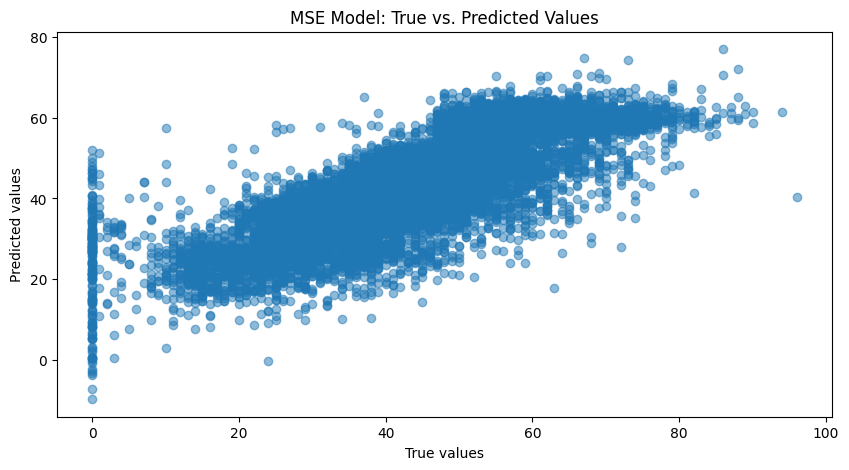

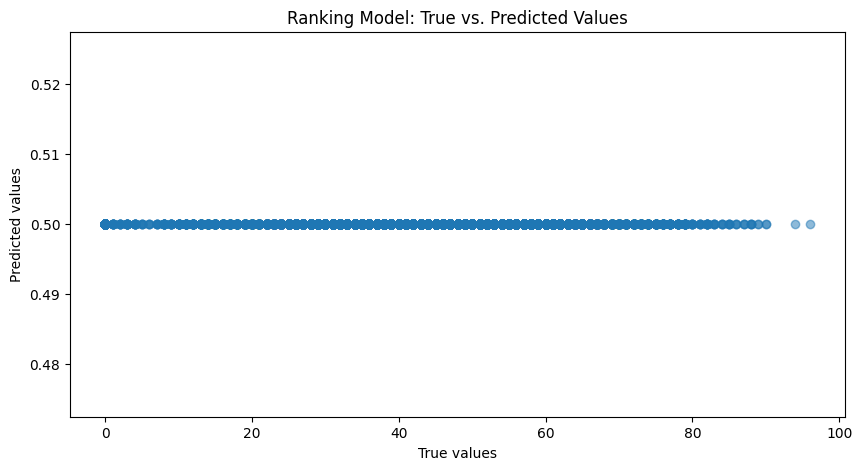

In [15]:
# Plot true vs. predicted values for MSE model
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_mse, alpha=0.5)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('MSE Model: True vs. Predicted Values')
plt.show()

# Plot true vs. predicted values for ranking model
plt.figure(figsize=(10, 5))
plt.scatter(y_test, y_pred_rank, alpha=0.5)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Ranking Model: True vs. Predicted Values')
plt.show()

# tree_clf.fit(X_train,y_train)

In [38]:
tree_clf.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1; total time=  41.2s
[CV] END gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1; total time=  41.2s
[CV] END gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1; total time=  41.3s
[CV] END gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1; total time=  41.3s
[CV] END gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1; total time=  41.4s
[CV] END gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1; total time= 1.1min
[CV] END gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1; total time= 1.1min
[CV] END gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1; total time= 1.1min
[CV] END gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1; total time= 1.1min
[CV] END gamma=0.0, learning_rate=0.05, max_depth=4, min_child_weight=1; total time= 1.1min
[CV] END gamma=0.0,

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.0, 0.1], 'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1]},
             scoring=make_scorer(accuracy_score), verbose=2)

## Best parameters

In [39]:
# # print('Best Criterion:', tree_clf_gs.best_estimator_.get_params()['criterion'])
# print('Best max_depth:', tree_clf.best_estimator_.get_params()['max_depth'])
# print('Best min_samples_split:', tree_clf.best_estimator_.get_params()['min_samples_split'])
# print('Best min_samples_leaf:', tree_clf.best_estimator_.get_params()['min_samples_leaf'])
# # print(); 
# # print(clf_GS.best_estimator_.get_params()['dec_tree'])

best_params = tree_clf.best_params_
best_estimator = tree_clf.best_estimator_

print("Best parameters found: ", best_params)
print("Best estimator found: ", best_estimator)

Best parameters found:  {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1}
Best estimator found:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


In [56]:
print(df.columns)

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5',
       'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'genre_0',
       'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6',
       'genre_7', 'genre_8', 'genre_9', 'Minor', 'Major'],
      dtype='object')


In [62]:
# Train the XGBoost model


# model = xgb.XGBClassifier()
# model.fit(X_train, y_train)

# Get the feature importances from the model
feature_importances = best_estimator.feature_importances_

# Calculate F1 scores for each feature by removing the feature and retraining the model
features_to_remove_list = [
    [0],  # Indices of features to remove in the first iteration
    [1],
    [2],
    [3],
    [4],
    [5],
    [6],
    [7],
    [8],
    [9],
    [10,11,12,13,14,15,16,17,18,19,20,21],
    [22,23,24,25,26,27,28],
    [29,30]   # Indices of features to remove in the second iteration
]

# Calculate F1 scores for each combination of manually specified features removed
f1_scores = {}
for features_to_remove in features_to_remove_list:
    X_train_dropped = np.delete(X_train, features_to_remove, axis=1)
    X_test_dropped = np.delete(X_test, features_to_remove, axis=1)
    
    dropped_model = best_estimator
    dropped_model.fit(X_train_dropped, y_train)
    y_pred = dropped_model.predict(X_test_dropped)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores[tuple(features_to_remove)] = f1


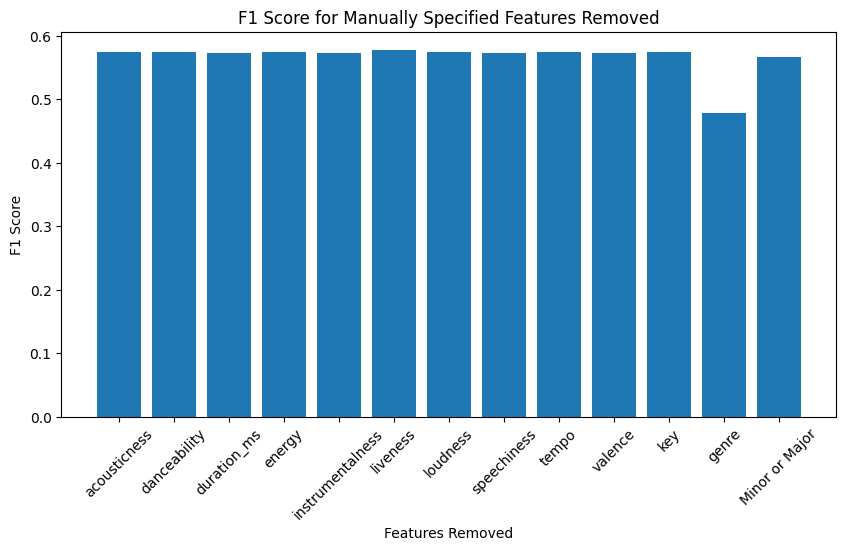

In [66]:
# # Visualize the F1 scores
# plt.bar(range(X_train.shape[1]), f1_scores, tick_label=df.drop('popularity', axis=1).columns)
# plt.xlabel('Features')
# plt.ylabel('F1 Score')
# plt.title('F1 Score for Each Feature')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.show()

x_labels = ['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key', 'genre', 'Minor or Major'
]
# Visualize the F1 scores
plt.figure(figsize=(10, 5))
plt.bar(range(len(f1_scores)), f1_scores.values(), tick_label=x_labels)
plt.xlabel('Features Removed')
plt.ylabel('F1 Score')
plt.title('F1 Score for Manually Specified Features Removed')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [67]:
print(df.columns)

Index(['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5',
       'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11', 'genre_0',
       'genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5', 'genre_6',
       'genre_7', 'genre_8', 'genre_9', 'Minor', 'Major'],
      dtype='object')


In [74]:
# Train the XGBoost model


# model = xgb.XGBClassifier()
# model.fit(X_train, y_train)

# Get the feature importances from the model
feature_importances = best_estimator.feature_importances_

# Calculate F1 scores for each feature by removing the feature and retraining the model
features_to_remove_list = [
    [0, 1, 2, 3, 4, 5, 6 ,7],  # Indices of features to remove in the first iteration
    [8, 9, 10,11,12,13,14,15,16,17,18,19,20,21],
    [22,23,24,25,26,27,28],
    [29,30]   # Indices of features to remove in the second iteration
]

# Calculate F1 scores for each combination of manually specified features removed
f1_scores = {}
for features_to_remove in features_to_remove_list:
    X_train_dropped = np.delete(X_train, features_to_remove, axis=1)
    X_test_dropped = np.delete(X_test, features_to_remove, axis=1)
    
    dropped_model = best_estimator
    dropped_model.fit(X_train_dropped, y_train)
    y_pred = dropped_model.predict(X_test_dropped)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores[tuple(features_to_remove)] = f1

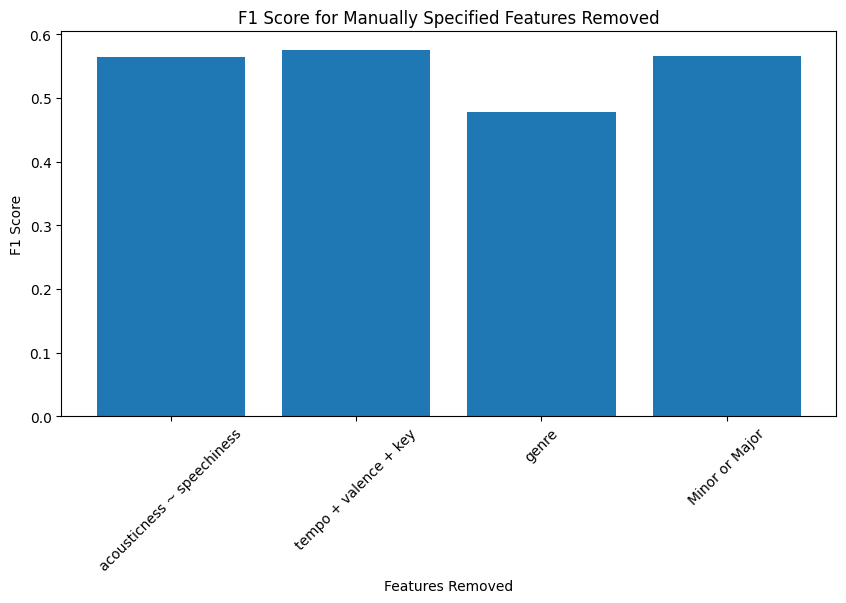

In [75]:
# # Visualize the F1 scores
# plt.bar(range(X_train.shape[1]), f1_scores, tick_label=df.drop('popularity', axis=1).columns)
# plt.xlabel('Features')
# plt.ylabel('F1 Score')
# plt.title('F1 Score for Each Feature')
# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# plt.show()

x_labels = ['acousticness ~ speechiness', 'tempo + valence + key', 'genre', 'Minor or Major' ]
# Visualize the F1 scores
plt.figure(figsize=(10, 5))
plt.bar(range(len(f1_scores)), f1_scores.values(), tick_label=x_labels)
plt.xlabel('Features Removed')
plt.ylabel('F1 Score')
plt.title('F1 Score for Manually Specified Features Removed')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()


In [ ]:

y_pred = best_estimator.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: {:.2f}".format(accuracy))



## Results

In [16]:
from sklearn.metrics import f1_score

# Get the feature importances from the model
feature_importances = best_estimator.feature_importances_

# Calculate F1 scores for each feature by removing the feature and retraining the model
f1_scores = []
for i in range(X_train.shape[1]):
    X_train_dropped = np.delete(X_train, i, axis=1)
    X_test_dropped = np.delete(X_test, i, axis=1)

    dropped_model = xgb.XGBClassifier()
    dropped_model.fit(X_train_dropped, y_train)
    y_pred = dropped_model.predict(X_test_dropped)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)

# Visualize the F1 scores
plt.bar(range(X_train.shape[1]), f1_scores, tick_label=X.feature_names)
plt.xlabel('Features')
plt.ylabel('F1 Score')
plt.title('F1 Score for Each Feature')
plt.show()

ValueError: Shape of passed values is (32444, 32), indices imply (32444, 33)

In [14]:
y_pred_train = tree_clf.predict(X_train)

In [15]:
# training score
accuracy_score(y_pred_train, y_train)

0.6072309209715202

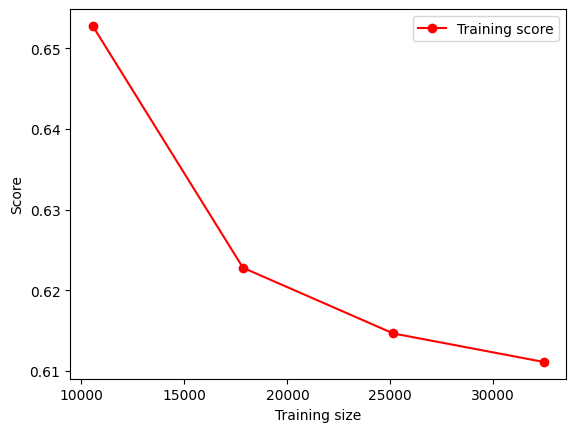

In [55]:
def plot_learning_curve(model, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    # plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.xlabel('Training size')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.show()

plot_learning_curve(best_estimator, X, y)

In [82]:
print(y_test.head)
y_test = y_test.values
print(y_test)
# # y_test[1978]
# print(type(y_pred))


AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [83]:

print(confusion_matrix(y_test, y_pred))
print("Classification report\n")
print(classification_report(y_test, y_pred))

# Calculate the fraction of correctly ordered pairs && Ranking SVM

n_correct = 0
n_pairs = 0

try:
    for i in range(len(y_test)):
        for j in range(i + 1, len(y_test)):
            if (y_test[i] < y_test[j]) == (y_pred[i] < y_pred[j]):
                n_correct += 1
            n_pairs += 1
except KeyError:
    print(f'Invalid column index: {i}')
except IndexError:
    print(f'Invalid row index: {i}')
except Exception as e:
    print(f'An unexpected error occurred: {e}')






[[1734  387    5    6]
 [ 654 1139  211    5]
 [ 190  543  602  795]
 [  46  186  283 1326]]
Classification report

              precision    recall  f1-score   support

           0       0.66      0.81      0.73      2132
           1       0.51      0.57      0.53      2009
           2       0.55      0.28      0.37      2130
           3       0.62      0.72      0.67      1841

    accuracy                           0.59      8112
   macro avg       0.58      0.60      0.58      8112
weighted avg       0.58      0.59      0.57      8112



## Plotting Graphs

In [84]:
print(f'Fraction of correctly ordered pairs: {n_correct / n_pairs}')

Fraction of correctly ordered pairs: 0.8206725860149985


In [62]:
from sklearn.metrics import roc_curve, roc_auc_score
# predict probabilities
lr_probs = tree_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]



ValueError: Feature shape mismatch, expected: 34, got 12

In [63]:
from matplotlib import pyplot
from numpy import sqrt, argmax, save
import numpy as np
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
np.save("fpr_DT", fpr)
np.save("tpr_DT", tpr)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

NameError: name 'lr_probs' is not defined